In [1]:
import numpy as np
from rerf.urerf import UnsupervisedRandomForest
import matplotlib.pyplot as plt

In [15]:
def generate_circle(n, r=5, theta0=0, acorn=1):
    np.random.seed(acorn)
    
    thetas = np.random.uniform(0, 2*np.math.pi, n-1)
    
    Xs = np.array([np.array([r * np.cos(theta), r * np.sin(theta)]) for theta in thetas])
    X0 = np.array([r*np.cos(theta0), r*np.sin(theta0)])
    Xs = np.concatenate(([X0], Xs))
        
    distances = np.array([min([np.pi * (2*np.pi - (theta - theta0))*r, np.pi* (theta - theta0)*r]) for theta in thetas])
    
    nearest_neighbors_idx = np.argsort(distances)
    
    return Xs, nearest_neighbors_idx

def get_kprimes(true_nn, rf_nn):
    kprimes = []
    n = len(true_nn) + 1
    for k in range(1, n):
        knn = set(true_nn[:k])

        n_found = 0
        i = 0
        while n_found < k:
            if rf_nn[i] in knn:
                n_found += 1
            i += 1
        kprimes.append(i)
    return np.array(kprimes)
    
def experiment(n, r=5, theta0=0, mc_its=200, fixed_k=0, acorn=1):
    np.random.seed(acorn)
    
    if fixed_k == 0:
        kprimes = np.zeros((mc_its, n-1))
        mean_kprimes = np.zeros(n-1)
        std_kprimes = np.zeros(n-1)
    else:
        kprimes = np.zeros(mc_its)
    
    for i in range(mc_its):
        Xs, true_nn = generate_circle(n, r, theta0, acorn=i + n*i)
        
        clf = UnsupervisedRandomForest(projection_matrix="RerF", random_state=0)
        clf.fit(Xs)
        W = 1 - clf.transform()
        rf_nn = np.argsort(W[0, 1:])
                
        if fixed_k == 0:
            kprimes[i] = get_kprimes(true_nn, rf_nn)
        else:
            kprimes[i] = get_kprimes(true_nn, rf_nn)[fixed_k - 1]
            
    if fixed_k == 0:        
        return np.mean(kprimes, axis=0), np.std(kprimes, ddof=1, axis=0)
    else:
        return np.mean(kprimes), np.std(kprimes, ddof=1)

def experiment_fixedk(n, k, r=5, theta0=0, mc_its=200, acorn=1):
    np.random.seed(acorn)
    
    kprimes = np.zeros(mc_its)
    mean_kprimes = np.zeros(n-1)
    std_kprimes = np.zeros

In [3]:
from tqdm import tqdm

ns = np.array([100, 200, 500, 1000, 2000])
mc_its = 100
theta0 = 0
r = 5

means = []
stds = []

for i, n in enumerate(tqdm(ns)):
    temp = experiment(n, r, theta0, mc_its, acorn=i)
    means.append(temp[0])
    stds.append(temp[1])

100%|██████████| 5/5 [08:06<00:00, 132.88s/it]


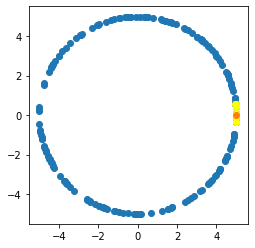

In [10]:
n=200
k=10
Xs, nn = generate_circle(n)

knn = nn[:k]


fig, ax = plt.subplots(1,1)
ax.scatter(Xs[:, 0], Xs[:, 1])
ax.scatter(Xs[1:, :][knn,0], Xs[1:, :][knn,1], c = 'yellow')
ax.scatter(5*np.cos(0), 5*np.sin(0))

ax.set_aspect('equal')
plt.savefig('circle_r5_k10.png')

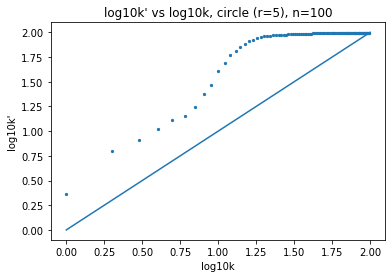

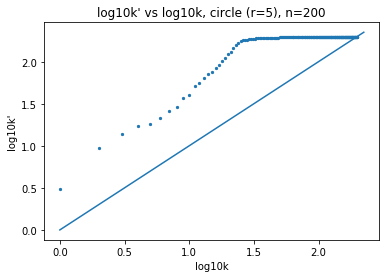

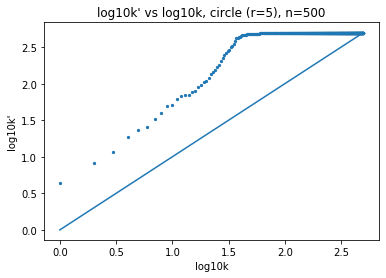

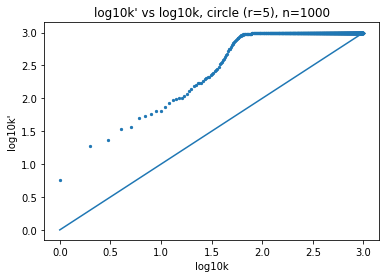

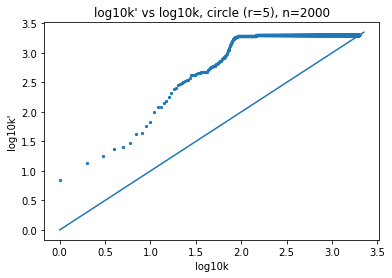

In [36]:
for i, n in enumerate(ns):
    fig, ax = plt.subplots(1,1)
    ax.scatter(np.log10(np.array(range(1, n))), np.log10(means[i]), s = 5)
    ax.set_title("log10k' vs log10k, circle (r=5), n=%i"%(n))
    ax.set_xlabel('log10k')
    ax.set_ylabel("log10k'")
    ax.plot(np.arange(0, np.log10(n) + 0.05, step=0.05), np.arange(0, np.log10(n) + 0.05, step=0.05))
    plt.savefig('circle_r5_loglog_n%i'%(n) + '.png')

In [26]:
from tqdm import tqdm

h=100
ns_ = np.arange(h, 1000+h, step = h)
ns_ = np.concatenate((ns_, [1250, 1500, 2000]))

mc_its_ = 200
theta0_ = 0
r_ = 5

means_ = []
stds_ = []

for i, n in enumerate(tqdm(ns_)):
    temp = experiment(n, r_, theta0_, mc_its_, acorn=i, fixed_k=20)
    means_.append(temp[0])
    stds_.append(temp[1])


100%|██████████| 13/13 [45:15<00:00, 463.59s/it]

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(ns_, means_, s = 5)
ax.set_title("k' vs n, circle (r=5), k=%i"%(20))
ax.set_xlabel('n')
ax.set_ylabel("k'")
ax.plot(np.arange(1, n, step=0.05), np.arange(1, n, step=0.05), label='y=n')
ax.plot(np.arange(1, n, step=0.05), np.log10(np.arange(1, n, step=0.05)), label='y=log10n')
ax.legend()

plt.savefig('circle_r5_k20' + '.png')

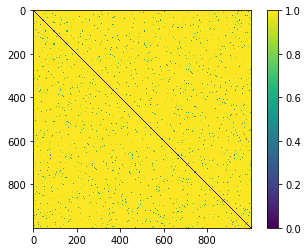

In [109]:
clf = UnsupervisedRandomForest(projection_matrix="RerF", random_state=0)
clf.fit(Xs)
W = 1 - clf.transform()
plt.imshow(W)
plt.colorbar()

In [110]:
rf_nn = np.argsort(W[0, 1:])

k_primes = []
for k in range(n - 1):
    knn = set(nn[:k])
    
    n_found = 0
    i = 0
    while n_found < k:
        if rf_nn[i] in knn:
            n_found += 1
        i += 1
    k_primes.append(i)

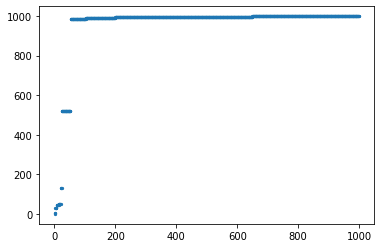

In [113]:
fig, ax = plt.subplots(1,1)
ax.scatter(range(1, n), k_primes, s = 5)
# ax.plot(np.arange(1, n), np.arange(1, n) + np.log(n))